In [31]:
%load_ext autoreload
%autoreload 2
import os

os.chdir("/home/jorge/thesis")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim_tag = 'rumba_zoom_20:latest'
anim_tag = 'rumba_zoom_out_src:latest'
anim_tag = 'mv_helmet:latest'
anim_tag = 'lion_zoom_out_src:latest'
anim_tag = 'mv_cat_statue:latest'
anim = AnimationArtifact.from_wandb_artifact_tag(anim_tag)
seq = anim.read_anim_seq()

In [55]:
from text3d2video.mip import seq_max_uv_res

seq_max_uv_res(seq, resolution=64)

176

In [56]:
from text3d2video.utilities.ipython_utils import display_ims

In [57]:
frame_i = 0
cam = seq.cams[frame_i]
mesh = seq.meshes[frame_i]
verts_uvs = seq.verts_uvs
faces_uvs = seq.faces_uvs

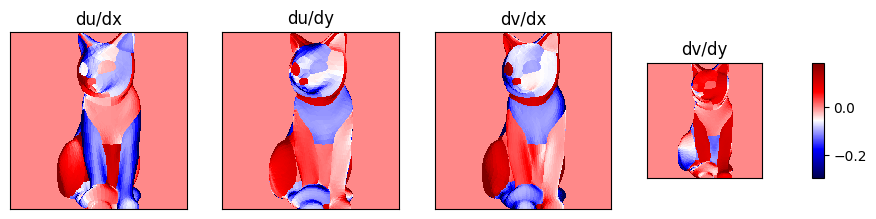

: 

In [ ]:
from matplotlib import pyplot as plt
from text3d2video.mip import (
    broadcast_face_attribute,
    compute_face_mip_level,
    compute_face_uv_grads,
)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from text3d2video.rendering import make_mesh_rasterizer


face_uv_grads = compute_face_uv_grads(mesh, cam, verts_uvs, faces_uvs)

rasterizer = make_mesh_rasterizer()
frags = rasterizer(mesh, cameras=cam)
pix_to_face = frags.pix_to_face[0, ..., 0]
du_dx = broadcast_face_attribute(pix_to_face, face_uv_grads.du_dx).cpu()
du_dy = broadcast_face_attribute(pix_to_face, face_uv_grads.du_dy).cpu()
dv_dx = broadcast_face_attribute(pix_to_face, face_uv_grads.dv_dx).cpu()
dv_dy = broadcast_face_attribute(pix_to_face, face_uv_grads.dv_dy).cpu()

vmin = du_dx.quantile(0.01).item()
vmax = du_dx.quantile(0.99).item()

scale = 3
fig, axs = plt.subplots(1, 4, figsize=(3.5 * scale, 1 * scale))

kwargs = dict(
    cmap="seismic",
    vmin=vmin,
    vmax=vmax,
    interpolation="none",
)

im = axs[0].imshow(du_dx, **kwargs)
axs[0].set_title("du/dx")
im = axs[1].imshow(du_dy, **kwargs)
axs[1].set_title("du/dy")
im = axs[2].imshow(dv_dx, **kwargs)
axs[2].set_title("dv/dx")
im = axs[3].imshow(dv_dy, **kwargs)
axs[3].set_title("dv/dy")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

divider = make_axes_locatable(axs[-1])
cax = divider.append_axes("right", size="10%", pad=0.5)

# Use the first imshow object for colorbar
plt.colorbar(im, cax=cax)
plt.show()

tensor(0.0013, device='cuda:0')


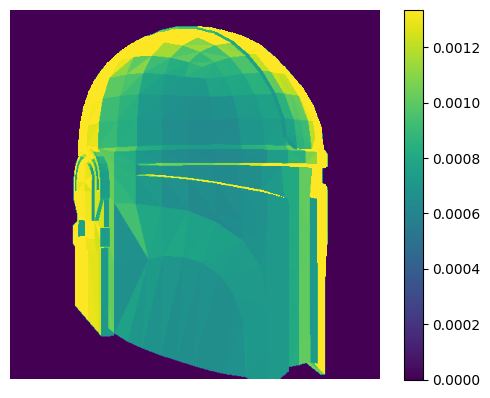

In [10]:
from matplotlib import pyplot as plt
from text3d2video.mip import render_mip_level_map, view_uv_res

mip = render_mip_level_map(mesh, cam, verts_uvs, faces_uvs, uv_res=1)
mip_summary = mip[mip > 0].quantile(0.90)

print(mip_summary)

plt.imshow(mip.cpu(), vmax=mip_summary)
plt.axis('off')
plt.colorbar()

# Verify Computing UV res for a view

To compute the uv resolution for a view, we find one that leads to minimal warping. Assigned resolution is correct if squares look like the same size in both images

537


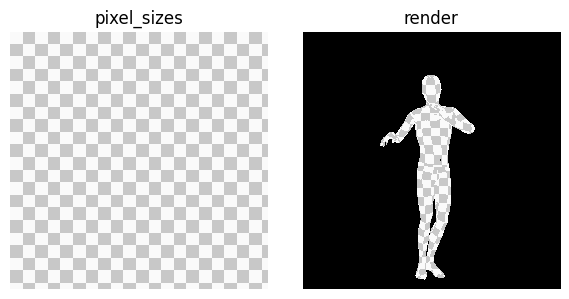

: 

In [ ]:
import torchvision.transforms.functional as TF

from text3d2video.mip import view_uv_res
from text3d2video.rendering import render_texture
from text3d2video.util import chw_to_hwc, hwc_to_chw
from text3d2video.utilities.testing_utils import checkerboard_img

resolution = 512
uv_res = view_uv_res(
    cam, mesh, verts_uvs, faces_uvs, resolution=resolution, quantile=0.1
)

print(uv_res)

n_squares = 20
square_size = int(resolution / n_squares)

tex = TF.to_tensor(checkerboard_img(res=uv_res, square_size=square_size)).cuda()
tex = chw_to_hwc(tex).cuda()
tex_im = TF.to_pil_image(hwc_to_chw(tex.cpu()))

pixel_sizes = checkerboard_img(res=resolution, square_size=square_size)

render = render_texture(
    mesh,
    cam,
    tex,
    verts_uvs,
    faces_uvs,
    return_pil=True,
    resolution=resolution,
    sampling_mode="nearest",
)[0]

ims = {}
# ims["tex"] = tex_im
ims["pixel_sizes"] = pixel_sizes
ims["render"] = render

display_ims(list(ims.values()), titles=list(ims.keys()))